In [65]:
import os
from collections import defaultdict, Counter

import pandas as pd
import matplotlib.pyplot as plt

In [66]:
from utils.config import TOPIC_KEYWORDS, BASE_MODEL_NAME

In [67]:
IG_ROOT = IG_ROOT = os.path.join("checkpoints/ig", BASE_MODEL_NAME)
OUT_ROOT = "checkpoints/ig_trends"
TOPIC_DIR = "checkpoints/topics"

In [68]:
YEARS = list(range(2015, 2025))
TOP_K_FOR_PLOT = 10
TOP_N_PER_YEAR = 30
RANK_CUTOFF_FOR_PLOT = 20
MIN_YEARS_APPEAR = 3
MIN_CONSECUTIVE_YEARS = 2

print("Topics:", list(TOPIC_KEYWORDS.keys()))
print("Years:", YEARS)

Topics: ['racism', 'police', 'immigration']
Years: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [69]:
def load_ig_for_topic_year(topic: str, year: int):
    path = os.path.join(IG_ROOT, f"{topic}_{year}_token_attributions.csv")
    if not os.path.isfile(path):
        print(f"[WARN] IG file not found: {path}")
        return None
    df = pd.read_csv(path)
    df = df.sort_values("avg_attr", ascending=False).reset_index(drop=True)
    return df


In [70]:
def build_rankings_for_side(topic: str, side: str):
    assert side in ("cnn", "fox")

    yearly_lists = {}
    years_with_data = []

    for year in YEARS:
        df = load_ig_for_topic_year(topic, year)
        if df is None or df.empty:
            continue

        if side == "cnn":
            df_side = df[df["avg_attr"] > 0.15].sort_values("avg_attr", ascending=False)
        else:  # fox
            df_side = df[df["avg_attr"] < 0.15].sort_values("avg_attr", ascending=True)

        if df_side.empty:
            continue

        top_tokens = df_side["token"].head(TOP_N_PER_YEAR).tolist()
        yearly_lists[year] = top_tokens
        years_with_data.append(year)

    years_with_data.sort()
    return years_with_data, yearly_lists


In [71]:
def build_vocabulary_from_yearly_lists(yearly_lists):
    from collections import defaultdict

    token_years = defaultdict(set)  # token -> set(years)

    for year, tokens in yearly_lists.items():
        for tok in set(tokens):
            token_years[tok].add(year)

    vocab = set()

    for tok, years_set in token_years.items():
        years_list = sorted(years_set)
        if len(years_list) < MIN_CONSECUTIVE_YEARS:
            continue

        max_run = 1
        cur_run = 1
        for i in range(1, len(years_list)):
            if years_list[i] == years_list[i - 1] + 1:
                cur_run += 1
                max_run = max(max_run, cur_run)
            else:
                cur_run = 1

        if max_run >= MIN_CONSECUTIVE_YEARS:
            vocab.add(tok)

    return vocab, token_years

In [72]:
def select_top_tokens_for_plot(vocab, token_years, yearly_lists):
    if not vocab:
        return []

    metrics = []
    for tok in vocab:
        years = token_years[tok]
        ranks = []
        for y in years:
            tokens = yearly_lists.get(y, [])
            if tok in tokens:
                ranks.append(tokens.index(tok) + 1)  # 1-based
        if not ranks:
            continue
        years_count = len(years)
        avg_rank = sum(ranks) / len(ranks)
        metrics.append((tok, years_count, avg_rank))

    # 按 years_count 降序，avg_rank 升序 排序
    metrics.sort(key=lambda x: (-x[1], x[2]))
    selected_tokens = [m[0] for m in metrics[:TOP_K_FOR_PLOT]]
    return selected_tokens


In [73]:
def build_rank_matrix(years, yearly_lists, tokens_for_plot):
    data = {}
    for tok in tokens_for_plot:
        ranks = []
        for y in years:
            tokens = yearly_lists.get(y, [])
            if tok in tokens:
                rank = tokens.index(tok) + 1
                if rank <= RANK_CUTOFF_FOR_PLOT:
                    ranks.append(rank)
                else:
                    ranks.append(RANK_CUTOFF_FOR_PLOT + 1)  # 掉出 top10
            else:
                ranks.append(RANK_CUTOFF_FOR_PLOT + 1)  # 根本没出现
        data[tok] = ranks

    df_rank = pd.DataFrame(data, index=years)
    return df_rank


## dataset observations

In [74]:
def count_words(text: str) -> int:
    if not isinstance(text, str):
        return 0
    return len(text.split())


def load_topic_year_words(topic: str, year: int):
    fname = f"topic_{topic}_{year}.csv"
    path = os.path.join(TOPIC_DIR, fname)
    if not os.path.isfile(path):
        print(f"[WARN] file not found: {path}")
        return None

    df = pd.read_csv(path)
    if df.empty:
        return None

    assert {"network", "sentence"}.issubset(df.columns)

    df["word_count"] = df["sentence"].apply(count_words)
    agg = df.groupby("network")["word_count"].sum()
    return agg


records = []

for topic in TOPIC_KEYWORDS.keys():
    for year in YEARS:
        agg = load_topic_year_words(topic, year)
        if agg is None:
            continue
        for network, wcount in agg.items():
            records.append(
                {
                    "topic": topic,
                    "year": year,
                    "network": network,
                    "word_count": wcount,
                }
            )

stats_df = pd.DataFrame(records)
stats_df


,topic,year,network,word_count
0,racism,2015,cnn,96769
1,racism,2015,fox,9411
2,racism,2016,cnn,163943
3,racism,2016,fox,8887
4,racism,2017,cnn,88271
5,racism,2017,fox,16356
6,racism,2018,cnn,156636
7,racism,2018,fox,35437
8,racism,2019,cnn,261451
9,racism,2019,fox,70855


In [75]:
def format_millions(x):
    return f"{x / 1_000:.1f}K"


[  9411   8887  16356  35437  70855  48784 125818  48131  12216   4164] [ 96769 163943  88271 156636 261451 214120 156119  88667  78810  81533]


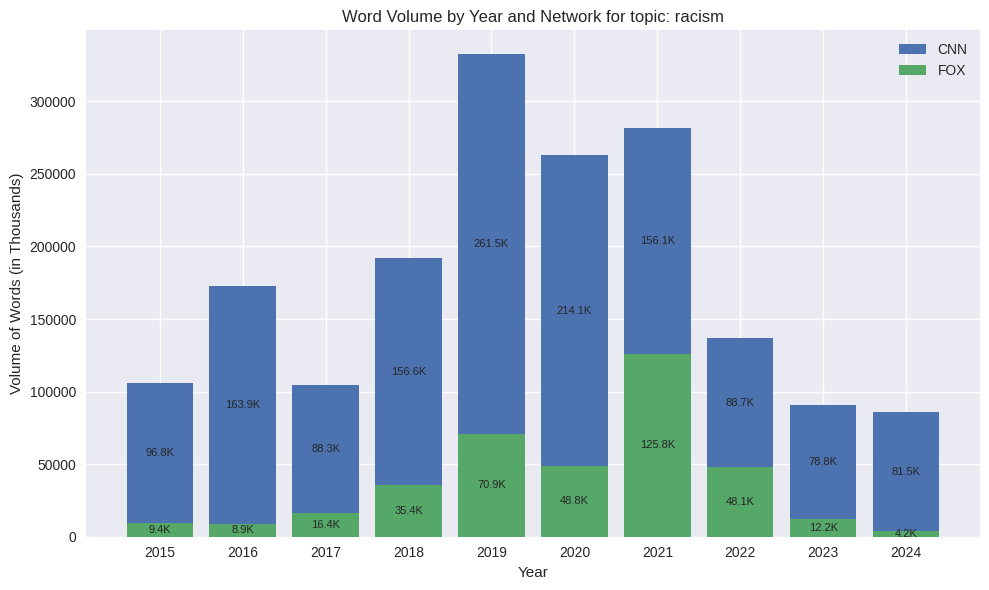

[DONE] saved figure: figures/word_volume_racism.png
[ 47740  34431  43876  51716  70965 152443 217790 101931  27972  15275] [1898590 1238674  750061  589638  703209  947673 1267260  863426  924940
  631450]


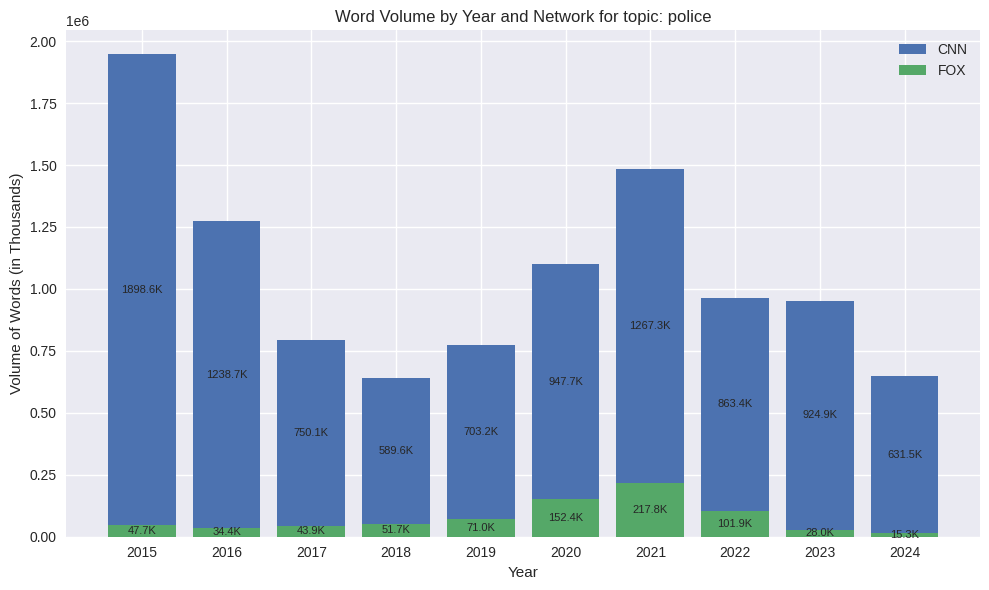

[DONE] saved figure: figures/word_volume_police.png
[ 28280  32845  59447 139085  97682  19215 101624  45656  13500  26015] [280651 432830 408574 646046 444040  84608 149089 126057 169309 460633]


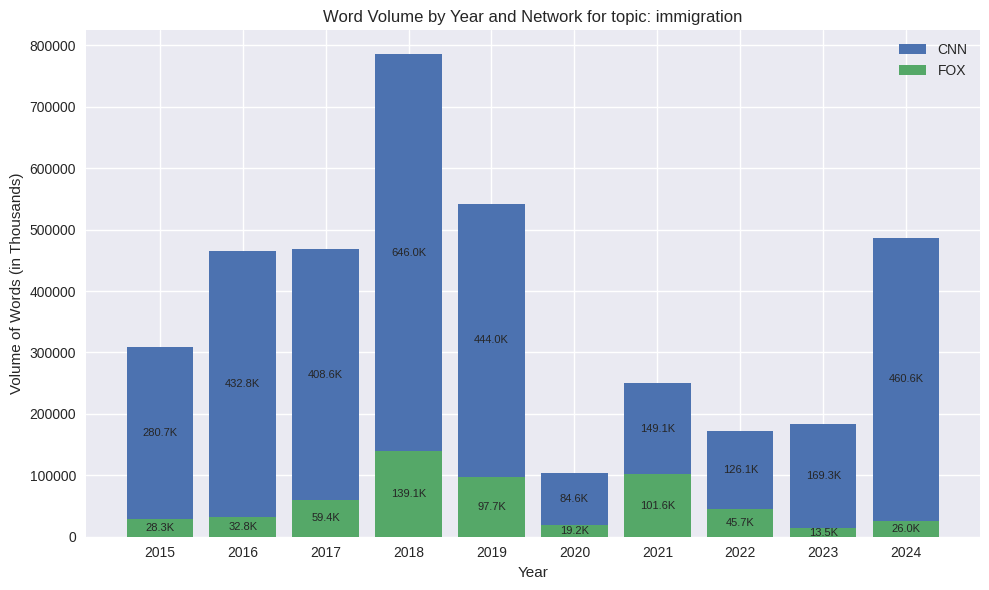

[DONE] saved figure: figures/word_volume_immigration.png


In [76]:
os.makedirs("figures", exist_ok=True)

for topic in TOPIC_KEYWORDS.keys():
    df_t = stats_df[stats_df["topic"] == topic].copy()
    if df_t.empty:
        print(f"[SKIP] no data for topic={topic}")
        continue

    pivot = df_t.pivot_table(
        index="year", columns="network", values="word_count", aggfunc="sum"
    ).fillna(0)

    years = sorted(pivot.index.tolist())

    for col in ["cnn", "fox"]:
        if col not in pivot.columns:
            pivot[col] = 0
    pivot = pivot[["cnn", "fox"]]

    cnn_vals = pivot["cnn"].values
    fox_vals = pivot["fox"].values

    x = range(len(years))

    plt.figure(figsize=(10, 6))

    bar_cnn = plt.bar(x, cnn_vals, bottom=fox_vals, label="CNN")
    bar_fox = plt.bar(x, fox_vals, label="FOX")

    print(fox_vals, cnn_vals)

    for i, (y_fox, y_cnn) in enumerate(zip(fox_vals, cnn_vals)):
        # FOX label
        if y_fox > 0:
            plt.text(
                i,
                y_fox / 2,
                format_millions(y_fox),
                ha="center",
                va="center",
                fontsize=8,
            )
        # CNN label
        if y_cnn > 0:
            plt.text(
                i,
                y_fox + y_cnn / 2,
                format_millions(y_cnn),
                ha="center",
                va="center",
                fontsize=8,
            )

    plt.xticks(x, years)
    plt.ylabel("Volume of Words (in Thousands)")
    plt.xlabel("Year")
    plt.title(f"Word Volume by Year and Network for topic: {topic}")
    plt.legend()

    plt.tight_layout()

    out_path = os.path.join("figures", f"word_volume_{topic}.png")
    plt.savefig(out_path, dpi=200)
    plt.show()

    print(f"[DONE] saved figure: {out_path}")


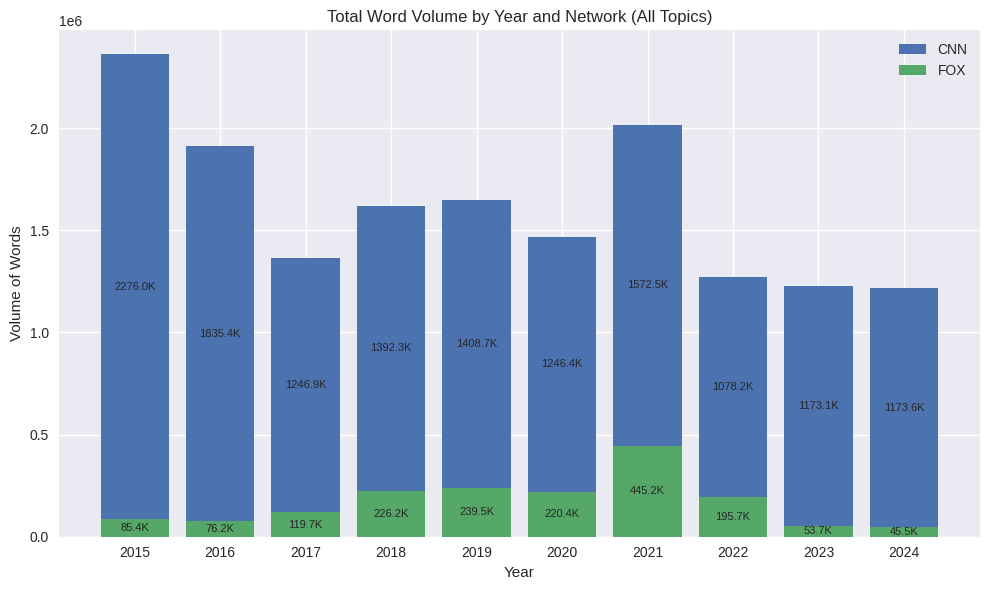

In [77]:
total_df = (
    stats_df.groupby(["year", "network"])["word_count"]
    .sum()
    .reset_index()
)

pivot_total = total_df.pivot_table(
    index="year", columns="network", values="word_count", aggfunc="sum"
).fillna(0)

years_total = sorted(pivot_total.index.tolist())

for col in ["cnn", "fox"]:
    if col not in pivot_total.columns:
        pivot_total[col] = 0
pivot_total = pivot_total[["cnn", "fox"]]

cnn_vals = pivot_total["cnn"].values
fox_vals = pivot_total["fox"].values

x = range(len(years_total))

plt.figure(figsize=(10, 6))

bar_cnn = plt.bar(x, cnn_vals, bottom=fox_vals, label="CNN")
bar_fox = plt.bar(x, fox_vals, label="FOX")

for i, (y_fox, y_cnn) in enumerate(zip(fox_vals, cnn_vals)):
    if y_fox > 0:
        plt.text(
            i,
            y_fox / 2,
            format_millions(y_fox),
            ha="center",
            va="center",
            fontsize=8,
        )
    if y_cnn > 0:
        plt.text(
            i,
            y_fox + y_cnn / 2,
            format_millions(y_cnn),
            ha="center",
            va="center",
            fontsize=8,
        )

plt.xticks(x, years_total)
plt.ylabel("Volume of Words")
plt.xlabel("Year")
plt.title("Total Word Volume by Year and Network (All Topics)")

plt.legend()

plt.tight_layout()

os.makedirs("figures", exist_ok=True)
out_path_total = os.path.join("figures", "word_volume_all_topics.png")
plt.savefig(out_path_total, dpi=200)
plt.show()

In [78]:
CLASSIFIER_ROOT = "checkpoints/classifier/roberta-base"
import json
import numpy as np


def load_fold_metrics(topic, year):
    fold_metrics = []
    for fold in range(3):
        metrics_path = os.path.join(
            CLASSIFIER_ROOT, topic, str(year), f"fold{fold}", "metrics.json"
        )
        if not os.path.isfile(metrics_path):
            print(f"[WARN] Missing metrics: {metrics_path}")
            return None
        with open(metrics_path, "r") as f:
            fold_metrics.append(json.load(f))

    avg = {}
    for key in ["eval_precision", "eval_recall", "eval_f1"]:
        avg[key[5:]] = float(np.mean([fm[key] for fm in fold_metrics]))
    return avg


records = []

for topic in TOPIC_KEYWORDS.keys():
    for year in YEARS:
        avg_metrics = load_fold_metrics(topic, year)
        if avg_metrics is None:
            continue
        records.append({
            "topic": topic,
            "year": year,
            "precision": avg_metrics["precision"],
            "recall": avg_metrics["recall"],
            "f1": avg_metrics["f1"],
        })

df = pd.DataFrame(records)
df.head()

,topic,year,precision,recall,f1
0,racism,2015,0.657236,0.420316,0.512010
1,racism,2016,0.615266,0.270270,0.374984
2,racism,2017,0.628548,0.428788,0.508518
3,racism,2018,0.693526,0.555849,0.616627
4,racism,2019,0.785816,0.597266,0.678097


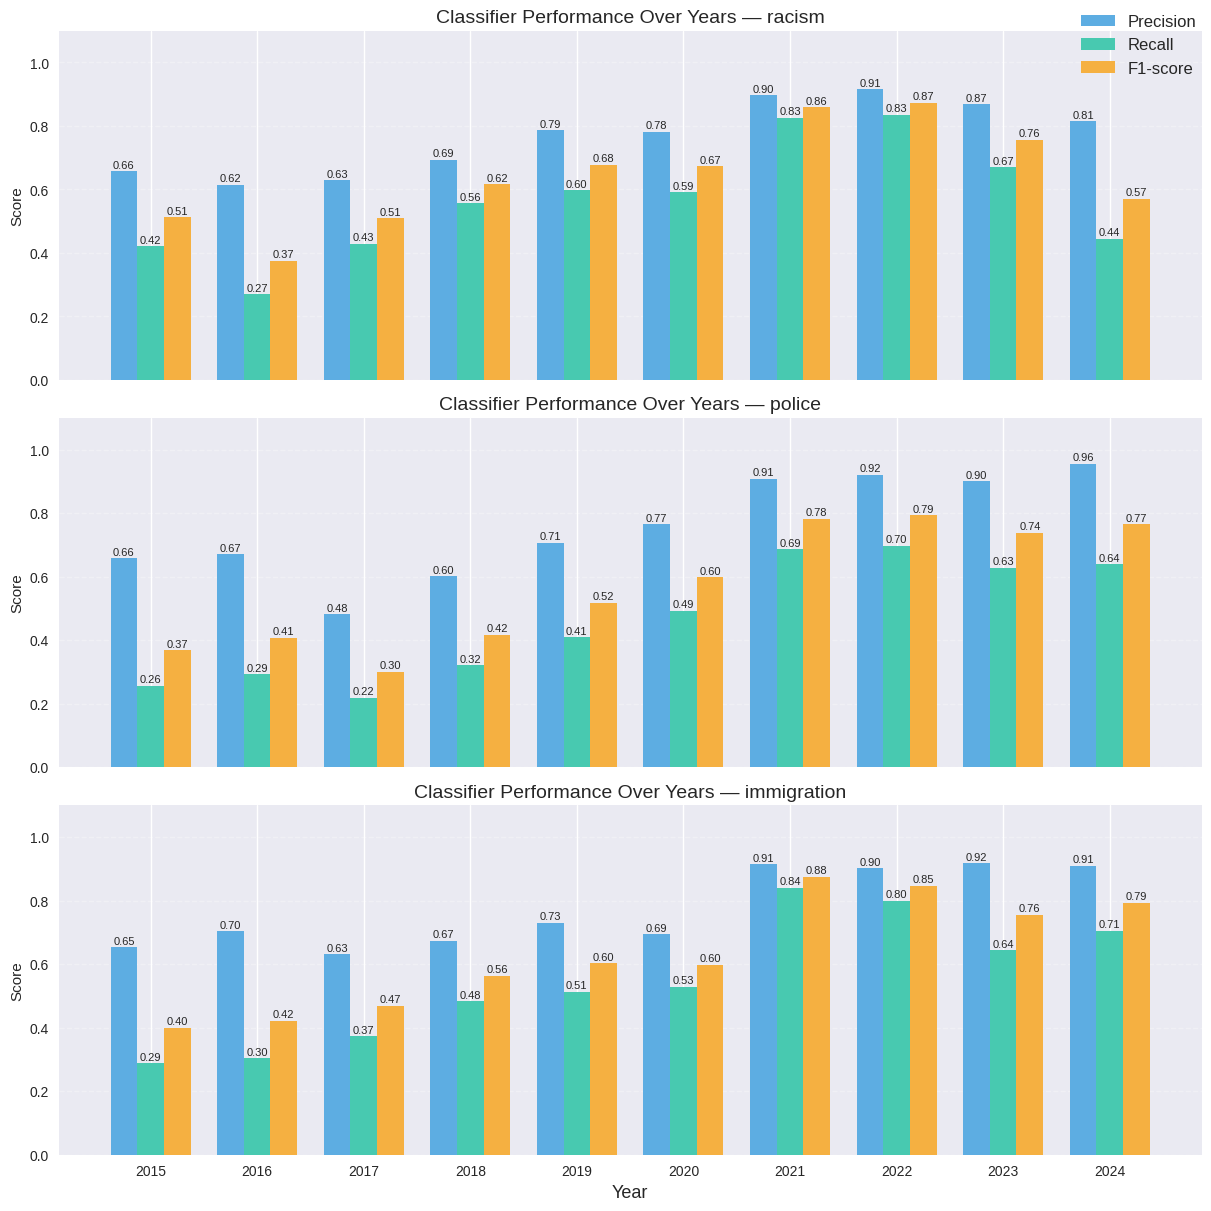

[DONE] Saved: figures/classifier_metrics/study2_all_topics_metrics_big.png


In [81]:
ordered_topics = list(TOPIC_KEYWORDS.keys())

fig, axes = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(12, 12),
    sharex=True,
    constrained_layout=True
)

for ax, topic in zip(axes, ordered_topics):
    df_t = df[df["topic"] == topic].copy()
    if df_t.empty:
        ax.set_title(f"(No data for topic: {topic})")
        continue

    df_t = df_t.sort_values("year")

    years = df_t["year"].tolist()
    precision_vals = df_t["precision"].tolist()
    recall_vals = df_t["recall"].tolist()
    f1_vals = df_t["f1"].tolist()

    x = np.arange(len(years))
    bar_width = 0.25

    ax.bar(x - bar_width, precision_vals, width=bar_width, label="Precision", color="#5DADE2")
    ax.bar(x, recall_vals, width=bar_width, label="Recall", color="#48C9B0")
    ax.bar(x + bar_width, f1_vals, width=bar_width, label="F1-score", color="#F5B041")

    for idx, (p, r, f) in enumerate(zip(precision_vals, recall_vals, f1_vals)):
        ax.text(x[idx] - bar_width, p + 0.01, f"{p:.2f}", ha="center", fontsize=8)
        ax.text(x[idx], r + 0.01, f"{r:.2f}", ha="center", fontsize=8)
        ax.text(x[idx] + bar_width, f + 0.01, f"{f:.2f}", ha="center", fontsize=8)

    ax.set_ylim(0, 1.1)
    ax.set_ylabel("Score")
    ax.set_title(f"Classifier Performance Over Years — {topic}", fontsize=14)
    ax.grid(axis="y", linestyle="--", alpha=0.3)

axes[-1].set_xticks(x)
axes[-1].set_xticklabels(years)
axes[-1].set_xlabel("Year", fontsize=13)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", fontsize=12)

os.makedirs("figures/classifier_metrics", exist_ok=True)
out_path = "figures/classifier_metrics/study2_all_topics_metrics_big.png"
plt.savefig(out_path, dpi=200)
plt.show()

print(f"[DONE] Saved: {out_path}")


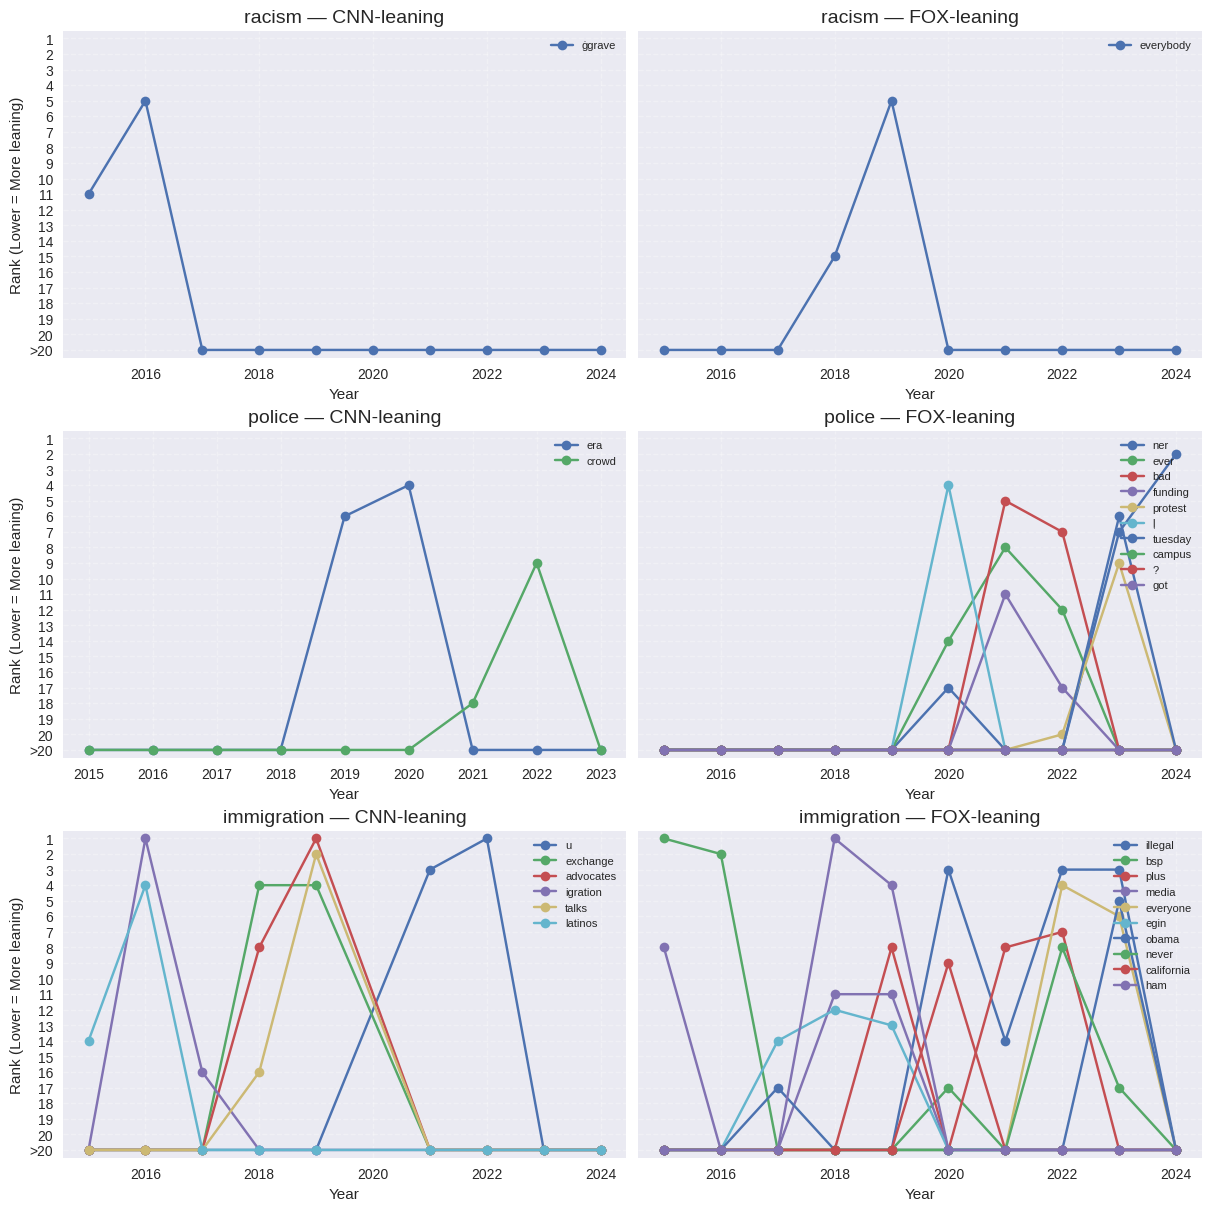

[DONE] saved 3x2 trends figure → figures/trends/study2_topic_rank_trends.png


In [84]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(12, 12),
    sharex=False,
    sharey=True,
    constrained_layout=True
)

sides = ["cnn", "fox"]
side_titles = ["CNN-leaning", "FOX-leaning"]

for col_idx, side in enumerate(sides):
    for row_idx, topic in enumerate(ordered_topics):

        ax = axes[row_idx][col_idx]

        years, yearly_lists = build_rankings_for_side(topic, side)
        if not years:
            ax.set_title(f"{topic} ({side_titles[col_idx]}) - No data")
            continue

        vocab, token_years = build_vocabulary_from_yearly_lists(yearly_lists)
        if not vocab:
            ax.set_title(f"{topic} ({side_titles[col_idx]}) - No tokens")
            continue

        tokens_for_plot = select_top_tokens_for_plot(vocab, token_years, yearly_lists)
        if not tokens_for_plot:
            ax.set_title(f"{topic} ({side_titles[col_idx]}) - No tokens (filtered)")
            continue

        df_rank = build_rank_matrix(years, yearly_lists, tokens_for_plot)

        # 绘制每个 token 的折线
        for tok in tokens_for_plot:
            ax.plot(
                years,
                df_rank[tok].values,
                marker="o",
                linestyle="-",
                label=tok
            )

        ax.invert_yaxis()
        ax.set_ylim(RANK_CUTOFF_FOR_PLOT + 1.5, 0.5)

        ax.set_title(f"{topic} — {side_titles[col_idx]}", fontsize=14)
        ax.set_xlabel("Year")
        if col_idx == 0:
            ax.set_ylabel("Rank (Lower = More leaning)")

        ax.set_yticks(
            list(range(1, RANK_CUTOFF_FOR_PLOT + 1)) + [RANK_CUTOFF_FOR_PLOT + 1]
        )
        ax.set_yticklabels(
            [str(i) for i in range(1, RANK_CUTOFF_FOR_PLOT + 1)] + [f">{RANK_CUTOFF_FOR_PLOT}"]
        )

        ax.legend(loc="upper right", fontsize=8)

        ax.grid(True, linestyle="--", alpha=0.3)

handles, labels = axes[0][0].get_legend_handles_labels()

os.makedirs("figures/trends", exist_ok=True)
out_path = "figures/trends/study2_topic_rank_trends.png"
plt.savefig(out_path, dpi=200)

plt.show()

print(f"[DONE] saved 3x2 trends figure → {out_path}")